In [4]:
import os
localfs_path = os.environ.get('SCRATCH_LOCAL') + '/'

In [5]:
os.environ['_JAVA_OPTIONS'] = f'-Djava.io.tmpdir={localfs_path}'

import hail as hl

hl.init(
    tmp_dir=(localfs_path+'tmp_hail_3'),
    spark_conf={'spark.driver.memory': '10G', 'spark.executor.memory': '10G'},
    default_reference='GRCh38'
) 

Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/3700043/
Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/3700043/


23/06/26 10:36:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://ac0082:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.113-cf32652c5077
LOGGING: writing to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/preprocessing/oligogenic-model/hail-20230626-1036-0.2.113-cf32652c5077.log


In [3]:
import sys
!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
import numpy as np
hl.plot.output_notebook()
import bokeh
from scipy import stats

from bokeh.plotting import figure, output_notebook, show
output_notebook

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from oligogenic_model import (
    read_in_pheno_anno_pw,
    aggregate_per_burden,
    stand_burden,
    stand_with_ref,
    read_in_pheno_anno_sport,
    model_assignment,
    read_in_pheno_anno_all
)

### Use average burden from polish controls for normalisation (this is the difference between this and the other mode)

In [8]:
mt = read_in_pheno_anno_sport(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'gts_sport_for_hist_')

2023-06-22 14:16:18.636 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
  Loading field 'f1' as type str (not specified)
  Loading field 'f2' as type str (not specified)
  Loading field 'f3' as type str (not specified)
  Loading field 'f4' as type str (not specified)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)
  Loading field 'f7' as type str (not specified)
  Loading field 'f8' as type str (not specified)
2023-06-22 14:16:19.561 Hail: INFO: Reading table without type imputation
  Loading field 'Gene stable ID' as type str (not specified)
  Loading field 'UniProtKB Gene Name symbol' as type str (not specified)
2023-06-22 14:16:20.656 Hail: INFO: Reading table to impute column types
2023-06-22 14:16:21.685 Hail: INFO: Finished type imputation
  Loading field 'ID' as type str (imputed)
  Loading field 'family' as type str (imputed)
  Loading field 'sex' as type str (imputed)
  Loading

In [9]:
reference = aggregate_per_burden(mt, 'gts_sport_for_hist_2')

2023-06-22 14:21:55.313 Hail: INFO: wrote matrix table with 6538550 rows and 204 columns in 488 partitions to /localfs/3700043/gts_sport_for_hist_2.mt
2023-06-22 14:27:18.577 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-06-22 14:28:02.463 Hail: INFO: wrote matrix table with 17844 rows and 204 columns in 488 partitions to /localfs/3700043/gts_sport_for_hist_2per_burden_agg.mt


In [10]:
reference = stand_burden(reference, 'gts_sport_for_hist_3')

2023-06-22 14:29:31.005 Hail: INFO: wrote matrix table with 17844 rows and 204 columns in 488 partitions to /localfs/3700043/gts_sport_for_hist_3stand_per_gene.mt


In [11]:
reference = hl.read_matrix_table('/localfs/3700043/gts_sport_for_hist_3stand_per_gene.mt')

In [11]:
mt_all = read_in_pheno_anno_all(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'gts_sport_for_hist_all'
)

2023-06-22 14:29:33.164 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
  Loading field 'f1' as type str (not specified)
  Loading field 'f2' as type str (not specified)
  Loading field 'f3' as type str (not specified)
  Loading field 'f4' as type str (not specified)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)
  Loading field 'f7' as type str (not specified)
  Loading field 'f8' as type str (not specified)
2023-06-22 14:29:33.744 Hail: INFO: Reading table without type imputation
  Loading field 'Gene stable ID' as type str (not specified)
  Loading field 'UniProtKB Gene Name symbol' as type str (not specified)
2023-06-22 14:29:34.597 Hail: INFO: Reading table to impute column types
2023-06-22 14:29:39.181 Hail: INFO: Finished type imputation
  Loading field 'ID' as type str (imputed)
  Loading field 'family' as type str (imputed)
  Loading field 'sex' as type str (imputed)
  Loading

In [ ]:
mt_all = aggregate_per_burden(mt_all, 'gts_sport_all')

2023-06-22 15:09:14.018 Hail: INFO: wrote matrix table with 6538550 rows and 287 columns in 488 partitions to /localfs/3700043/gts_sport_all.mt


In [25]:
mt_all.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 
        r_insertion_deletion: float64
    }
    'group': str
    'phenot

In [26]:
mt_all = hl.read_matrix_table('/localfs/3700043/gts_sport_allper_burden_agg.mt')

In [27]:
mt_all = stand_with_ref(
    mt_all,
    reference,
    'stand_with_gts_sport_4'
)

2023-06-23 14:50:41.678 Hail: INFO: wrote table with 17844 rows in 488 partitions to /localfs/3700043/stand_with_gts_sport_4ref_rows.mt


x


2023-06-23 14:50:48.712 Hail: INFO: wrote matrix table with 17844 rows and 287 columns in 488 partitions to /localfs/3700043/stand_with_gts_sport_4res_anno_temp1.mt
2023-06-23 14:50:53.661 Hail: INFO: wrote matrix table with 17844 rows and 287 columns in 488 partitions to /localfs/3700043/stand_with_gts_sport_4res_anno_temp2.mt
2023-06-23 14:50:57.999 Hail: INFO: wrote matrix table with 17844 rows and 287 columns in 488 partitions to /localfs/3700043/stand_with_gts_sport_4res_anno_temp3.mt
2023-06-23 14:51:02.360 Hail: INFO: wrote matrix table with 17844 rows and 287 columns in 488 partitions to /localfs/3700043/stand_with_gts_sport_4res_anno.mt
2023-06-23 14:51:07.094 Hail: INFO: wrote matrix table with 17844 rows and 287 columns in 488 partitions to /localfs/3700043/stand_with_gts_sport_4stand_per_gene_with_ref.mt


In [10]:
mt = hl.read_matrix_table('/localfs/3700043/stand_with_gts_sport_4stand_per_gene_with_ref.mt')

In [11]:
cadds = [0,5,10,16,20,25,30]

In [12]:
mt.count()

(17844, 287)

### Draw a per-group histogram of oligogenic scores

In [13]:
genes = ['CHADL', 'DRD2', 'MAOA', 'PCDH10', 'HTR2A', 'SLITRK5', 'SORCS3', 'KCNQ5', 'CDH9', 'CHD8']

In [14]:
mt = mt.filter_rows(
        hl.literal(genes).contains(mt.nearest_genes_20kb)
    )

In [15]:
cadds = [0,5,10,16,20,25,30]

In [16]:
assignments = mt.annotate_cols(
        **{
            f'n_non_ref_above_cadd_sum_{c}': hl.agg.sum(mt[f'per_gene_stdev_above_cadd_{c}'])
            for c in cadds
        },
        **{
            f'n_non_ref_weited_above_cadd_sum_{c}': hl.agg.sum(mt[f'per_gene_stdev_weited_above_cadd_{c}'])
            for c in cadds
        }
    )

In [17]:
assignments = assignments.annotate_cols(
    test_group = hl.if_else(
        assignments.group == 'local_controls',
        'sport',
        hl.if_else(
            assignments.phenotypes.disease == 'NO',
            'healthy_family_members',
            hl.if_else(
                ((assignments.phenotypes.phenotype == 'GTS') & (assignments.phenotypes.family == '.')),
                'GTS_sporadic',
                 hl.if_else(
                     assignments.phenotypes.phenotype == 'GTS',
                     'GTS_familial',
                     'tics'
                 )
            )
        )
    )
)

In [18]:
assignments.aggregate_cols(hl.agg.counter(assignments.test_group))

{'GTS_familial': 47,
 'GTS_sporadic': 40,
 'healthy_family_members': 55,
 'sport': 102,
 'tics': 43}

In [19]:
assignments = assignments.filter_cols(assignments.n_non_ref_above_cadd_sum_0 > -30)

# this excludes the following samples (with low quality)
#'S_7288', 'S_7289', 'S_7290', 'WGS_6827', 'WGS_6835'

In [20]:
def make_score_hist(assignments):
    
    sns.set(rc={'figure.figsize':(14,10)})
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    groups = ['GTS_familial',
              'GTS_sporadic',
              'healthy_family_members',
              'sport',
              'tics']
    
    all_samples = np.array(assignments.test_group.collect())
    
    
    for group in groups:
   
        subset = all_ass[np.where(all_samples == group)]
        palette = {
            'sport':sns.diverging_palette(220, 20)[0],
            'healthy_family_members':sns.diverging_palette(220, 20)[1],
            'tics':sns.diverging_palette(220, 20)[2],
            'GTS_familial':sns.diverging_palette(220, 20)[3],
            'GTS_sporadic':sns.diverging_palette(220, 20)[4]
        }
        
       
        # Draw the density plot
        sns.histplot(subset, kde = True,
                     label = group,
                     stat="percent",
                     kde_kws=dict(cut=3),
                     alpha=.4,
                     binrange=[-10,10],
                     binwidth=1,
                     color=palette[group]
                    )
        

    
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'Airline')
    plt.title('Density Plot with Multiple Airlines')
    plt.xlabel('Delay (min)')
    plt.ylabel('Density')
    plt.savefig("hists.png")
    
    
    return(plt)

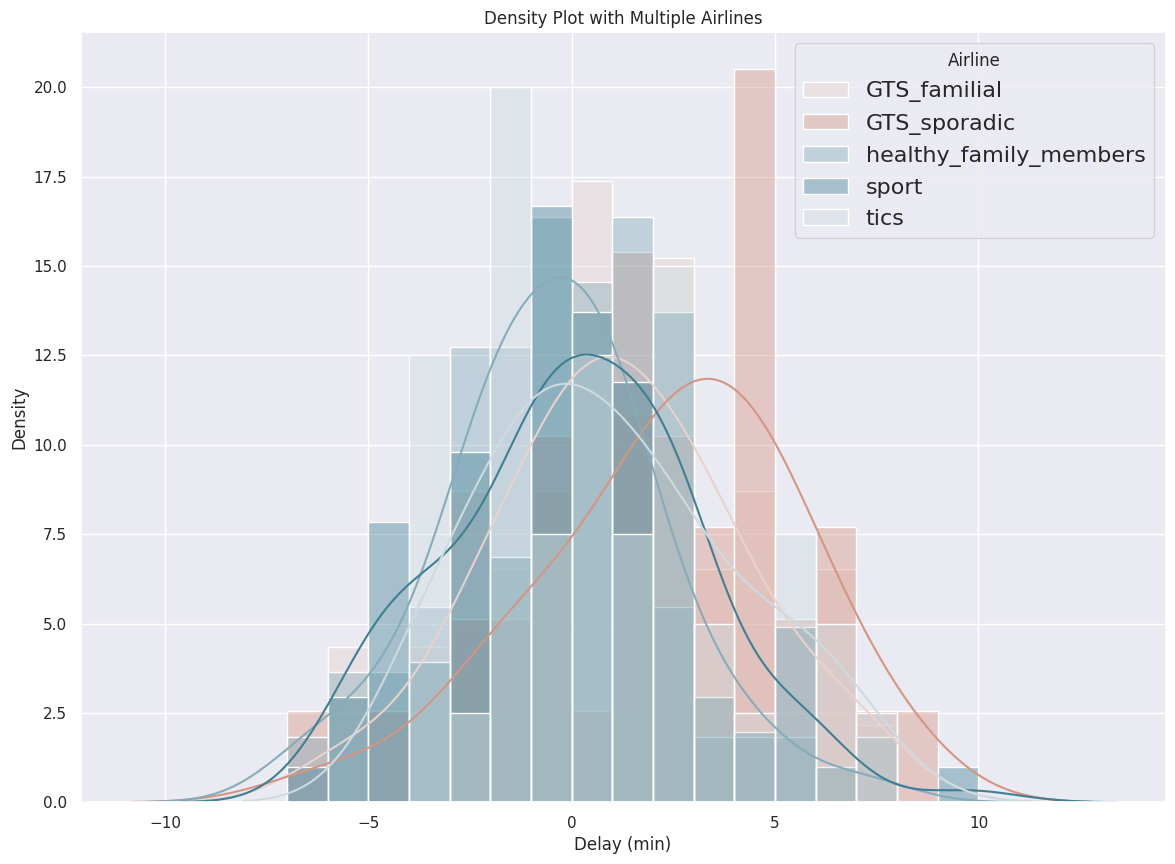

In [21]:
p = make_score_hist(assignments)

In [30]:
def make_score_box(assignments):
    
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set(font_scale=1.5)
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    groups = ['GTS_familial',
              'GTS_sporadic',
              'healthy_family_members',
              'sport',
              'tics']
    
    palette = {
            'sport':sns.diverging_palette(220, 20)[0],
            'healthy_family_members':sns.diverging_palette(220, 20)[1],
            'tics':sns.diverging_palette(220, 20)[2],
            'GTS_familial':sns.diverging_palette(220, 20)[3],
            'GTS_sporadic':sns.diverging_palette(220, 20)[4]
        }
    
    all_samples = np.array(assignments.test_group.collect())
    
    sns.boxplot(
        x=all_samples,
        y=all_ass,
        hue=all_samples,
        dodge=False,
        palette=palette,     
        order=['sport',
               'healthy_family_members',
               'tics',
               'GTS_familial',
               'GTS_sporadic']
    )
    
    
    # Plot formatting
    plt.title('oligogenic score per group')
    plt.xlabel('group')
    plt.ylabel('score value')
    plt.legend([],[], frameon=False)
    plt.savefig("box.png")

    
    return(plt)

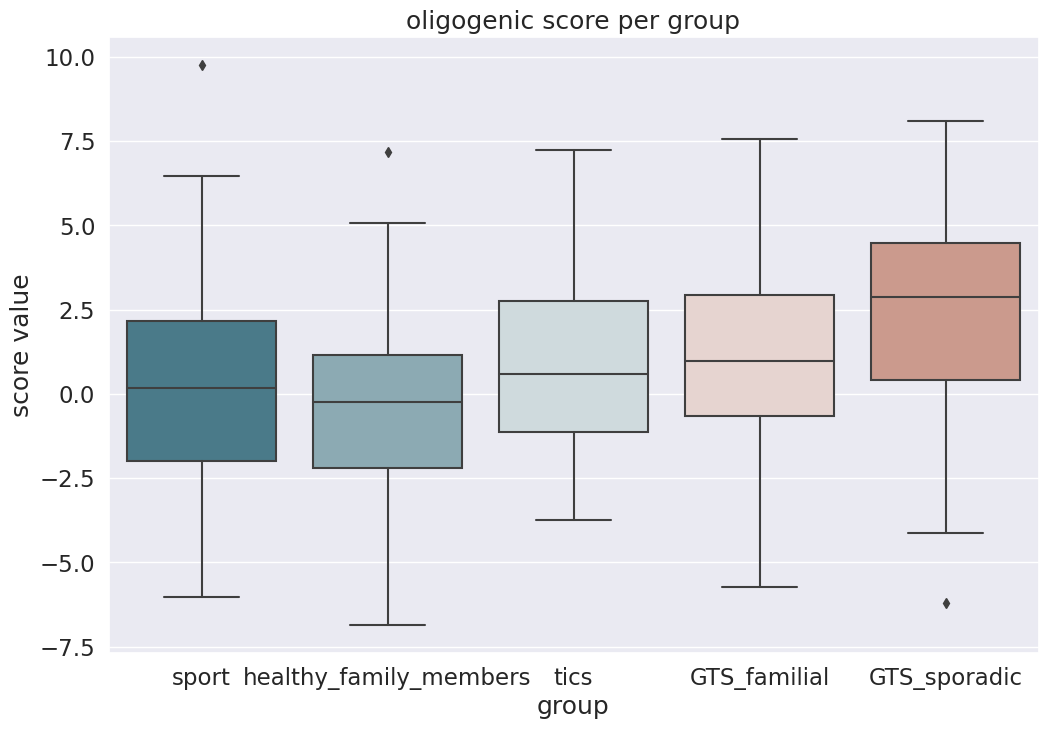

In [31]:
p = make_score_box(assignments)

In [32]:
from scipy.stats import f_oneway


In [33]:
all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
all_samples = np.array(assignments.test_group.collect())
    
subsets = []

groups = ['GTS_familial',
              'GTS_sporadic',
              'healthy_family_members',
              'sport',
              'tics']

for group in groups:
    subsets.append(all_ass[np.where(all_samples == group)]) 

In [34]:
f_oneway(*subsets)

F_onewayResult(statistic=6.2246473885179325, pvalue=8.258458058212514e-05)

In [40]:
print(groups[0], 'vs', groups[1], stats.ttest_ind(subsets[0], subsets[1]))

print(groups[0], 'vs', groups[2], stats.ttest_ind(subsets[0], subsets[2]))

print(groups[4], 'vs', groups[2], stats.ttest_ind(subsets[4], subsets[2]))

print(groups[0], 'vs', groups[4], stats.ttest_ind(subsets[0], subsets[4]))

print(groups[2], 'vs', groups[3], stats.ttest_ind(subsets[2], subsets[3]))

print(groups[0], 'vs', groups[3], stats.ttest_ind(subsets[0], subsets[3]))

print(groups[3], 'vs', groups[4], stats.ttest_ind(subsets[3], subsets[4]))

print(groups[3], 'vs', groups[1], stats.ttest_ind(subsets[3], subsets[1]))

print(groups[1], 'vs', groups[2], stats.ttest_ind(subsets[1], subsets[2]))

print(groups[4], 'vs', groups[1], stats.ttest_ind(subsets[4], subsets[1]))

GTS_familial vs GTS_sporadic Ttest_indResult(statistic=-1.9233445634362347, pvalue=0.05786545202625514)
GTS_familial vs healthy_family_members Ttest_indResult(statistic=2.692405934688229, pvalue=0.008331011236255395)
tics vs healthy_family_members Ttest_indResult(statistic=2.235749047297214, pvalue=0.027760537262227696)
GTS_familial vs tics Ttest_indResult(statistic=0.3139249648793477, pvalue=0.7543563150536539)
healthy_family_members vs sport Ttest_indResult(statistic=-1.10278336579664, pvalue=0.2718305360673089)
GTS_familial vs sport Ttest_indResult(statistic=1.836844196427626, pvalue=0.06826641828427835)
sport vs tics Ttest_indResult(statistic=-1.380454704068379, pvalue=0.1696467925304955)
sport vs GTS_sporadic Ttest_indResult(statistic=-3.9287313051593817, pvalue=0.00013401548005038816)
GTS_sporadic vs healthy_family_members Ttest_indResult(statistic=4.6118484811578515, pvalue=1.2853824903624763e-05)
tics vs GTS_sporadic Ttest_indResult(statistic=-2.1343478301965706, pvalue=0.03599

https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

In [ ]:
#gwas validation + PRS